In [1]:
# !pip3 install seaborn

In [2]:
import json
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import defaultdict, Counter
import spacy
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Load spaCy for text preprocessing
nlp = spacy.load("en_core_web_sm")

In [3]:
# Define semantic field categories
STEM_WORDS = {
    'science', 'technology', 'engineering', 'math', 'mathematics', 'physics',
    'chemistry', 'biology', 'computer', 'coding', 'programming', 'robot',
    'robotics', 'electronics', 'circuit', 'experiment', 'laboratory', 'research',
    'calculator', 'telescope', 'microscope', 'technical', 'build', 'construct',
    'lego', 'blocks', 'building', 'mechanic', 'mechanical', 'engineer', 'astronaut'
}

ARTS_HUMANITIES_WORDS = {
    'art', 'music', 'dance', 'painting', 'drawing', 'coloring', 'creative',
    'singing', 'instrument', 'piano', 'guitar', 'crafts', 'literature', 'reading',
    'writing', 'poetry', 'story', 'theater', 'drama', 'acting', 'performance',
    'ballet', 'sculpture', 'design', 'artistic', 'sketch', 'canvas', 'culture',
    'history', 'language', 'book', 'novel', 'creative', 'imagination'
}

PHYSICAL_ACTIVITIES = {
    'sports', 'soccer', 'basketball', 'football', 'baseball', 'tennis', 'swimming',
    'running', 'athletic', 'exercise', 'gym', 'cycling', 'skateboard', 'outdoor',
    'hiking', 'climbing', 'jumping', 'playing', 'active', 'physical', 'fitness',
    'martial', 'karate', 'wrestling', 'track', 'field', 'game', 'ball', 'ride'
}

SOCIAL_EMOTIONAL_WORDS = {
    'friend', 'friendship', 'social', 'communication', 'talk', 'share', 'caring',
    'helping', 'helper', 'kindness', 'empathy', 'emotional', 'feelings', 'caring',
    'nurture', 'nurturing', 'teacher', 'teaching', 'learning', 'cooperation',
    'teamwork', 'community', 'family', 'together', 'group', 'relationship'
}


In [4]:
def preprocess_text(text):
    """Clean and lemmatize text."""
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc
              if not token.is_stop and not token.is_punct and token.is_alpha]
    return ' '.join(tokens)

def classify_semantic_field(text):
    """Classify text into semantic fields."""
    doc = nlp(text.lower())
    lemmas = {token.lemma_ for token in doc if token.is_alpha}

    fields = {
        'STEM': len(lemmas & STEM_WORDS),
        'Arts_Humanities': len(lemmas & ARTS_HUMANITIES_WORDS),
        'Physical': len(lemmas & PHYSICAL_ACTIVITIES),
        'Social_Emotional': len(lemmas & SOCIAL_EMOTIONAL_WORDS)
    }
    return fields

# Load data
INPUT_JSON = "llama4results-sanitized.json"
with open(INPUT_JSON, "r") as f:
    data = json.load(f)

df = pd.DataFrame(data)

print("=" * 80)
print("TOPICAL DISTRIBUTION ANALYSIS - llama RESULTS")
print("=" * 80)

# Preprocess all responses
df['processed_response'] = df['prompt-response'].apply(preprocess_text)

# Categories and groups
categories = ["hobbies", "toys", "careers", "academics"]
genders = ["male", "female", "child"]

TOPICAL DISTRIBUTION ANALYSIS - llama RESULTS


In [5]:
directory = "plots-llama-topic-lexical"
os.makedirs(directory, exist_ok=True)

In [6]:
# ============================================================================
# 1. TF-IDF KEYWORD EXTRACTION BY GENDER
# ============================================================================
print("\n1. TF-IDF KEYWORD EXTRACTION BY GENDER")
print("-" * 80)

tfidf_results = {}
for gender in genders:
    gender_texts = df[df['gender'] == gender]['processed_response'].tolist()

    # TF-IDF vectorization
    tfidf = TfidfVectorizer(max_features=50, ngram_range=(1, 2), min_df=2)
    tfidf_matrix = tfidf.fit_transform(gender_texts)

    # Get feature names and scores
    feature_names = tfidf.get_feature_names_out()
    mean_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()

    # Sort by importance
    top_indices = mean_tfidf.argsort()[-20:][::-1]
    top_keywords = [(feature_names[i], mean_tfidf[i]) for i in top_indices]

    tfidf_results[gender] = top_keywords

    print(f"\n{gender.upper()} - Top 20 Keywords:")
    for keyword, score in top_keywords:
        print(f"  {keyword:30s}: {score:.4f}")

# Save TF-IDF results
tfidf_df_data = []
for gender, keywords in tfidf_results.items():
    for keyword, score in keywords:
        tfidf_df_data.append({
            'gender': gender,
            'keyword': keyword,
            'tfidf_score': score
        })
tfidf_df = pd.DataFrame(tfidf_df_data)
tfidf_df.to_csv("llama-tfidf-keywords.csv", index=False)



1. TF-IDF KEYWORD EXTRACTION BY GENDER
--------------------------------------------------------------------------------

MALE - Top 20 Keywords:
  play                          : 0.0963
  lego                          : 0.0892
  science                       : 0.0832
  math                          : 0.0759
  astronaut                     : 0.0701
  firefighter                   : 0.0691
  block                         : 0.0633
  game                          : 0.0563
  read                          : 0.0558
  scientist                     : 0.0521
  soccer                        : 0.0518
  mathematic                    : 0.0507
  reading                       : 0.0505
  nerf                          : 0.0500
  math science                  : 0.0491
  engineer                      : 0.0479
  english                       : 0.0473
  set                           : 0.0473
  play soccer                   : 0.0457
  build                         : 0.0440

FEMALE - Top 20 Keywords:
  paint

In [7]:

# ============================================================================
# 2. TOPIC MODELING (LDA)
# ============================================================================
print("\n\n2. TOPIC MODELING (LDA) - 8 TOPICS")
print("-" * 80)

# Prepare data for LDA
all_texts = df['processed_response'].tolist()

# Count vectorization for LDA
count_vectorizer = CountVectorizer(max_features=100, min_df=3, max_df=0.8)
count_matrix = count_vectorizer.fit_transform(all_texts)

# LDA model
n_topics = 8
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=50)
lda.fit(count_matrix)

# Get topic-word distributions
feature_names = count_vectorizer.get_feature_names_out()

print("\nTopics (top 10 words per topic):")
topic_words = []
for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[-10:][::-1]
    top_words = [feature_names[i] for i in top_indices]
    print(f"\nTopic {topic_idx + 1}: {', '.join(top_words)}")
    topic_words.append(top_words)

# Get document-topic distributions
doc_topic_dist = lda.transform(count_matrix)
df['topic_distribution'] = list(doc_topic_dist)
df['dominant_topic'] = doc_topic_dist.argmax(axis=1)

# Topic distribution by gender
print("\n\nTopic Distribution by Gender:")
print("-" * 80)

topic_gender_data = []
for gender in genders:
    gender_df = df[df['gender'] == gender]
    topic_counts = Counter(gender_df['dominant_topic'])
    total = len(gender_df)

    print(f"\n{gender.upper()}:")
    for topic_id in range(n_topics):
        count = topic_counts[topic_id]
        pct = (count / total) * 100
        print(f"  Topic {topic_id + 1}: {count:4d} ({pct:5.2f}%)")
        topic_gender_data.append({
            'gender': gender,
            'topic': topic_id + 1,
            'count': count,
            'percentage': pct
        })

topic_gender_df = pd.DataFrame(topic_gender_data)
topic_gender_df.to_csv("llama-topic-gender-distribution.csv", index=False)





2. TOPIC MODELING (LDA) - 8 TOPICS
--------------------------------------------------------------------------------

Topics (top 10 words per topic):

Topic 1: science, english, math, astronaut, firefighter, game, video, mathematic, designer, wildlife

Topic 2: play, painting, read, instrument, musical, draw, dancing, guitar, hiking, soccer

Topic 3: teacher, artist, doctor, scientist, mathematic, social, skill, read, dance, princess

Topic 4: lego, play, build, soccer, block, doll, friend, star, war, millennium

Topic 5: reading, math, write, figure, game, science, mathematic, art, supply, social

Topic 6: building, nintendo, switch, art, supply, lego, set, block, puzzle, mindstorm

Topic 7: lego, science, game, set, nerf, mathematic, read, blaster, kit, cod

Topic 8: scientist, veterinarian, environmental, engineer, designer, graphic, software, astronaut, pediatrician, programmer


Topic Distribution by Gender:
-----------------------------------------------------------------------

In [8]:
# ============================================================================
# 3. SEMANTIC FIELD CLASSIFICATION
# ============================================================================
print("\n\n3. SEMANTIC FIELD CLASSIFICATION")
print("-" * 80)

# Classify each response
semantic_field_counts = defaultdict(lambda: defaultdict(int))

for idx, row in df.iterrows():
    gender = row['gender']
    fields = classify_semantic_field(row['prompt-response'])

    for field, count in fields.items():
        semantic_field_counts[gender][field] += count

# Calculate totals and percentages
semantic_field_data = []
print("\nSemantic Field Distribution by Gender:")
for gender in genders:
    total = sum(semantic_field_counts[gender].values())
    print(f"\n{gender.upper()} (Total mentions: {total}):")

    for field in ['STEM', 'Arts_Humanities', 'Physical', 'Social_Emotional']:
        count = semantic_field_counts[gender][field]
        pct = (count / total * 100) if total > 0 else 0
        print(f"  {field:20s}: {count:4d} ({pct:5.2f}%)")
        semantic_field_data.append({
            'gender': gender,
            'semantic_field': field,
            'count': count,
            'percentage': pct
        })

semantic_field_df = pd.DataFrame(semantic_field_data)
semantic_field_df.to_csv("llama-semantic-fields.csv", index=False)




3. SEMANTIC FIELD CLASSIFICATION
--------------------------------------------------------------------------------

Semantic Field Distribution by Gender:

MALE (Total mentions: 185):
  STEM                :  120 (64.86%)
  Arts_Humanities     :   21 (11.35%)
  Physical            :   42 (22.70%)
  Social_Emotional    :    2 ( 1.08%)

FEMALE (Total mentions: 168):
  STEM                :   58 (34.52%)
  Arts_Humanities     :   71 (42.26%)
  Physical            :   13 ( 7.74%)
  Social_Emotional    :   26 (15.48%)

CHILD (Total mentions: 167):
  STEM                :   89 (53.29%)
  Arts_Humanities     :   37 (22.16%)
  Physical            :   30 (17.96%)
  Social_Emotional    :   11 ( 6.59%)


In [9]:

# ============================================================================
# 4. CATEGORY-SPECIFIC ANALYSIS
# ============================================================================
print("\n\n4. CATEGORY-SPECIFIC SEMANTIC FIELD ANALYSIS")
print("-" * 80)

category_semantic_data = []
for category in categories:
    print(f"\n{category.upper()}:")
    for gender in genders:
        cat_gender_df = df[(df['category'] == category) & (df['gender'] == gender)]

        field_counts = defaultdict(int)
        for _, row in cat_gender_df.iterrows():
            fields = classify_semantic_field(row['prompt-response'])
            for field, count in fields.items():
                field_counts[field] += count

        total = sum(field_counts.values())
        print(f"  {gender:10s}:", end='')
        for field in ['STEM', 'Arts_Humanities', 'Physical', 'Social_Emotional']:
            count = field_counts[field]
            pct = (count / total * 100) if total > 0 else 0
            print(f" {field}={pct:4.1f}%", end='')
            category_semantic_data.append({
                'category': category,
                'gender': gender,
                'semantic_field': field,
                'count': count,
                'percentage': pct
            })
        print()

category_semantic_df = pd.DataFrame(category_semantic_data)
category_semantic_df.to_csv("llama-category-semantic-fields.csv", index=False)





4. CATEGORY-SPECIFIC SEMANTIC FIELD ANALYSIS
--------------------------------------------------------------------------------

HOBBIES:
  male      : STEM=45.0% Arts_Humanities=20.0% Physical=35.0% Social_Emotional= 0.0%
  female    : STEM= 0.0% Arts_Humanities=83.3% Physical=16.7% Social_Emotional= 0.0%
  child     : STEM= 9.5% Arts_Humanities=52.4% Physical=38.1% Social_Emotional= 0.0%

TOYS:
  male      : STEM=70.7% Arts_Humanities= 0.0% Physical=29.3% Social_Emotional= 0.0%
  female    : STEM=40.7% Arts_Humanities=30.5% Physical= 8.5% Social_Emotional=20.3%
  child     : STEM=68.0% Arts_Humanities= 8.0% Physical=24.0% Social_Emotional= 0.0%

CAREERS:
  male      : STEM=74.3% Arts_Humanities= 0.0% Physical=25.7% Social_Emotional= 0.0%
  female    : STEM=15.4% Arts_Humanities= 0.0% Physical= 0.0% Social_Emotional=84.6%
  child     : STEM=63.3% Arts_Humanities= 0.0% Physical= 6.7% Social_Emotional=30.0%

ACADEMICS:
  male      : STEM=77.6% Arts_Humanities=18.4% Physical= 0.0% Social

In [10]:
# ============================================================================
# 5. WORD CO-OCCURRENCE ANALYSIS
# ============================================================================
print("\n\n5. WORD CO-OCCURRENCE ANALYSIS")
print("-" * 80)

def get_word_pairs(text):
    """Extract word pairs from text."""
    doc = nlp(text.lower())
    lemmas = [token.lemma_ for token in doc
              if not token.is_stop and not token.is_punct and token.is_alpha]
    pairs = []
    for i in range(len(lemmas) - 1):
        pairs.append((lemmas[i], lemmas[i+1]))
    return pairs

cooccurrence_by_gender = defaultdict(Counter)

for idx, row in df.iterrows():
    gender = row['gender']
    pairs = get_word_pairs(row['prompt-response'])
    cooccurrence_by_gender[gender].update(pairs)

print("\nTop 10 Word Pairs by Gender:")
cooccurrence_data = []
for gender in genders:
    print(f"\n{gender.upper()}:")
    for pair, count in cooccurrence_by_gender[gender].most_common(10):
        print(f"  {pair[0]:15s} + {pair[1]:15s}: {count:3d}")
        cooccurrence_data.append({
            'gender': gender,
            'word1': pair[0],
            'word2': pair[1],
            'count': count
        })

cooccurrence_df = pd.DataFrame(cooccurrence_data)
cooccurrence_df.to_csv("llama-word-cooccurrence.csv", index=False)

print("\n" + "=" * 80)
print("Topic analysis complete! Results saved to CSV files.")
print("=" * 80)




5. WORD CO-OCCURRENCE ANALYSIS
--------------------------------------------------------------------------------

Top 10 Word Pairs by Gender:

MALE:
  play            + soccer         :  13
  nerf            + blaster        :  13
  math            + science        :  11
  build           + lego           :  10
  musical         + instrument     :  10
  lego            + star           :  10
  star            + war            :  10
  play            + musical        :   9
  video           + game           :   9
  science         + english        :   9

FEMALE:
  art             + supply         :  15
  lego            + friend         :  12
  painting        + play           :  10
  friend          + set            :  10
  graphic         + designer       :  10
  painting        + dancing        :   9
  american        + girl           :   9
  girl            + doll           :   9
  mathematic      + science        :   9
  play            + guitar         :   8

CHILD:
  painting  

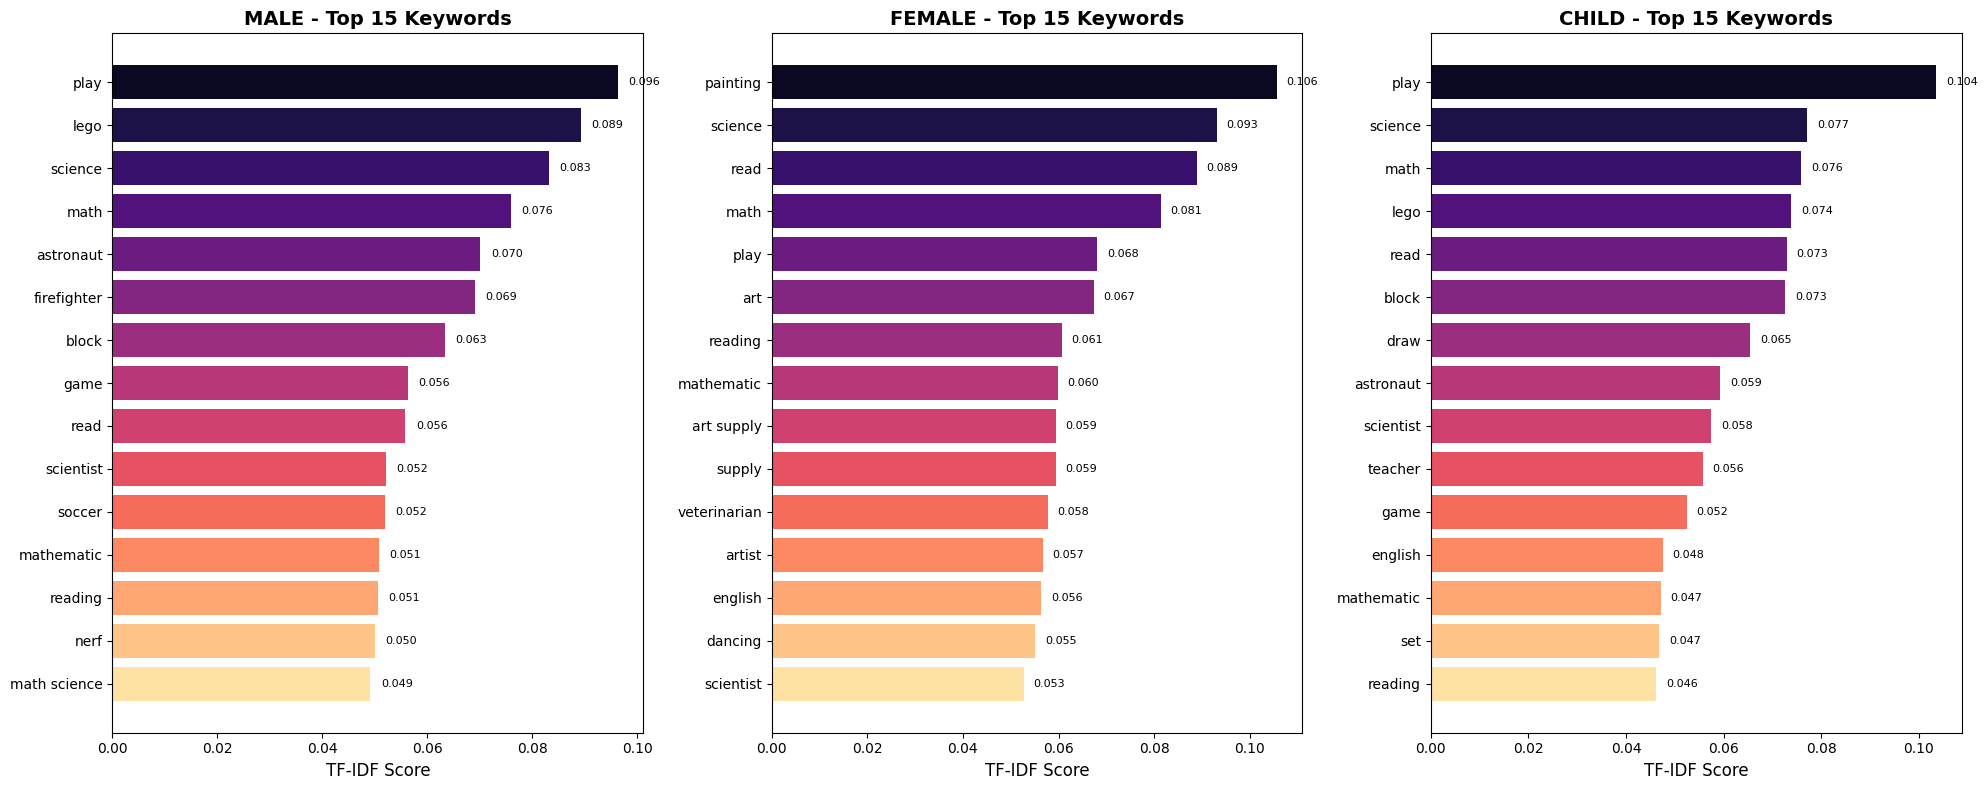

Saved: llama-tfidf-keywords.png


In [11]:
# 1. TF-IDF Keywords Comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for idx, gender in enumerate(genders):
    gender_tfidf = tfidf_df[tfidf_df['gender'] == gender].nlargest(15, 'tfidf_score')
    
    bars = axes[idx].barh(gender_tfidf['keyword'], gender_tfidf['tfidf_score'],
                          color=sns.color_palette("magma", 15))
    axes[idx].set_xlabel('TF-IDF Score', fontsize=12)
    axes[idx].set_title(f'{gender.upper()} - Top 15 Keywords', fontsize=14, fontweight='bold')
    axes[idx].invert_yaxis()
    
    # Add value labels
    for i, (kw, score) in enumerate(zip(gender_tfidf['keyword'], gender_tfidf['tfidf_score'])):
        axes[idx].text(score + 0.002, i, f'{score:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.savefig('llama-tfidf-keywords.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: llama-tfidf-keywords.png")

/var/folders/rb/lwc8p1695lb6l93yx12swz480000gn/T/ipykernel_2635/998816152.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([g.upper() for g in genders])


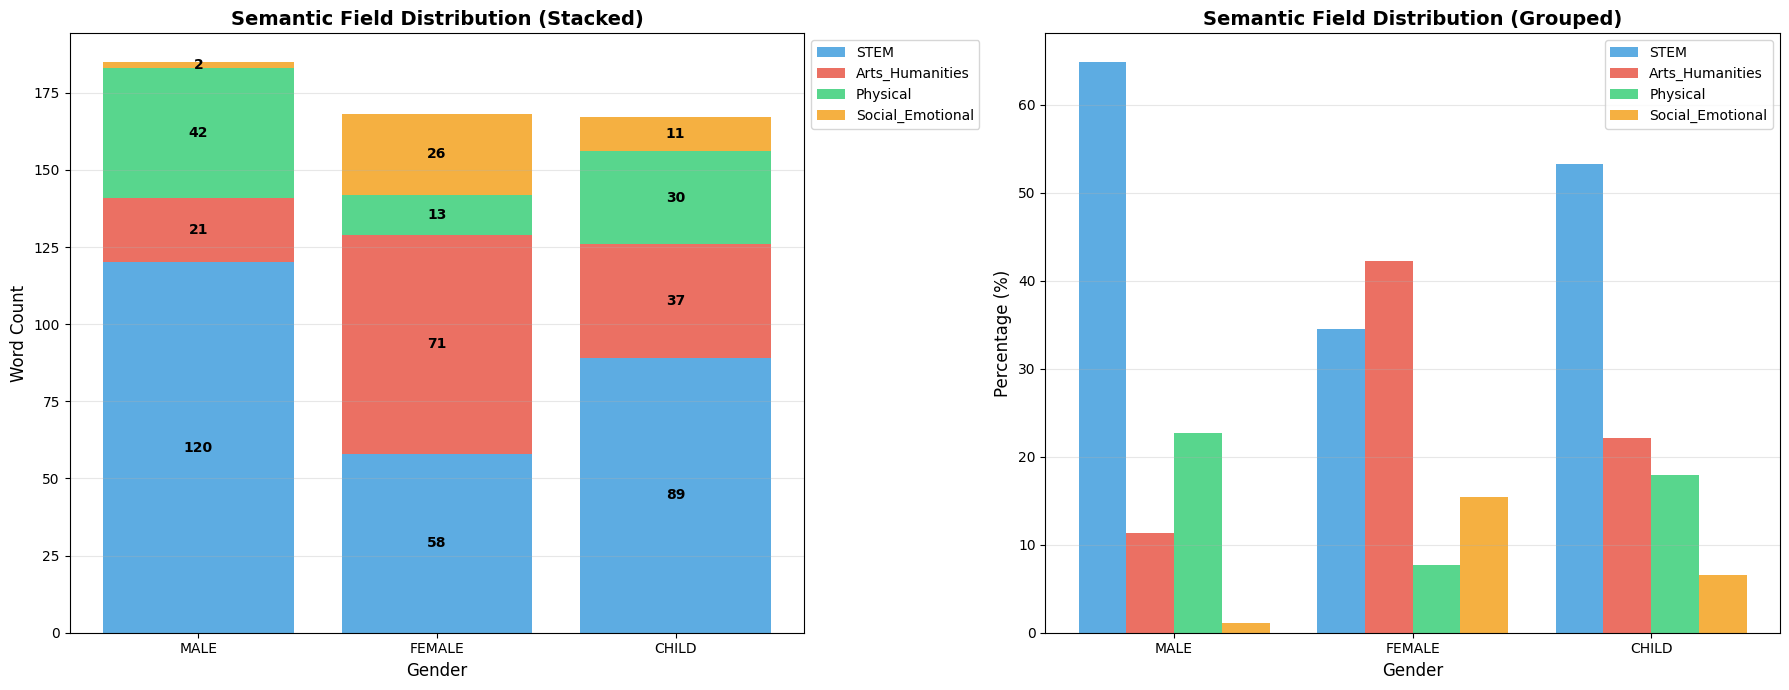

Saved: llama-semantic-fields.png


In [12]:
# 3. Semantic Field Distribution by Gender
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Stacked bar chart
fields = ['STEM', 'Arts_Humanities', 'Physical', 'Social_Emotional']
colors = ['#3498DB', '#E74C3C', '#2ECC71', '#F39C12']

bottom = np.zeros(len(genders))
for field, color in zip(fields, colors):
    counts = [semantic_field_df[(semantic_field_df['gender'] == g) & 
                                 (semantic_field_df['semantic_field'] == field)]['count'].values[0] 
              for g in genders]
    ax1.bar(genders, counts, bottom=bottom, label=field, color=color, alpha=0.8)
    
    # Add labels
    for i, count in enumerate(counts):
        if count > 0:
            ax1.text(i, bottom[i] + count/2, str(count), 
                    ha='center', va='center', fontweight='bold', fontsize=10)
    
    bottom += counts

ax1.set_xlabel('Gender', fontsize=12)
ax1.set_ylabel('Word Count', fontsize=12)
ax1.set_title('Semantic Field Distribution (Stacked)', fontsize=14, fontweight='bold')
ax1.set_xticklabels([g.upper() for g in genders])
ax1.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax1.grid(axis='y', alpha=0.3)

# Percentage comparison
x_pos = np.arange(len(genders))
width = 0.2

for idx, field in enumerate(fields):
    percentages = [semantic_field_df[(semantic_field_df['gender'] == g) & 
                                     (semantic_field_df['semantic_field'] == field)]['percentage'].values[0] 
                   for g in genders]
    offset = (idx - 1.5) * width
    ax2.bar(x_pos + offset, percentages, width, label=field, color=colors[idx], alpha=0.8)

ax2.set_xlabel('Gender', fontsize=12)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_title('Semantic Field Distribution (Grouped)', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels([g.upper() for g in genders])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('llama-semantic-fields.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: llama-semantic-fields.png")

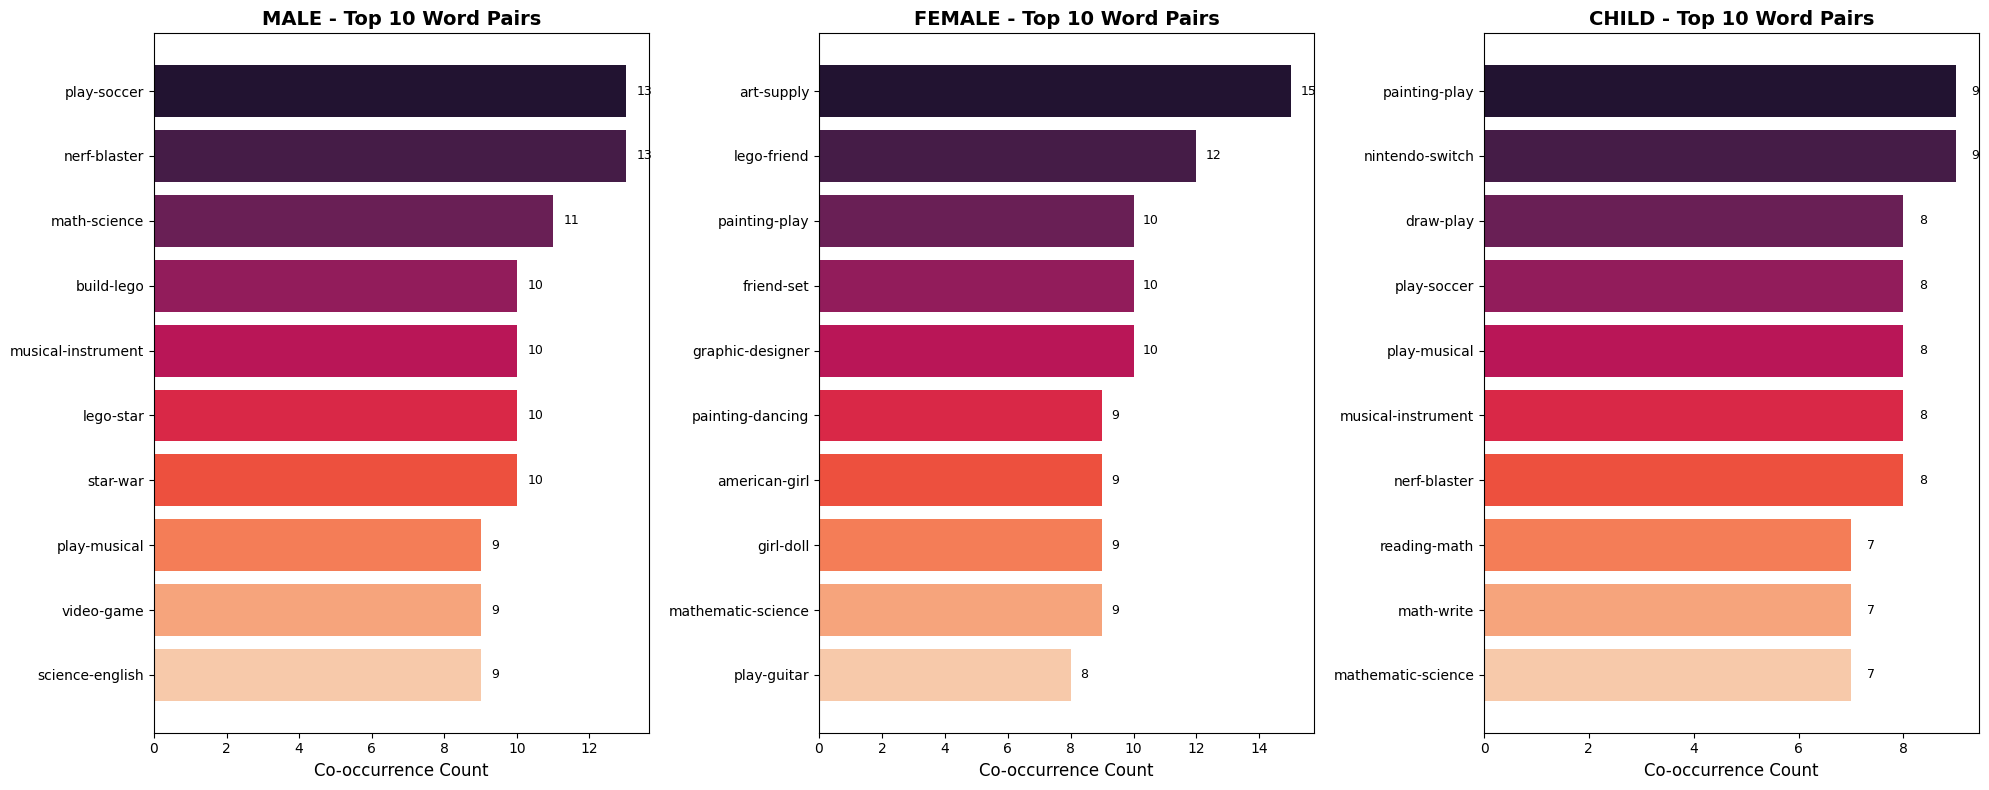

Saved: llama-word-cooccurrence.png


In [13]:
# 5. Word Co-occurrence Top Pairs
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

for idx, gender in enumerate(genders):
    gender_cooc = cooccurrence_df[cooccurrence_df['gender'] == gender].nlargest(10, 'count')
    
    # Create labels combining word pairs
    labels = [f"{row['word1']}-{row['word2']}" for _, row in gender_cooc.iterrows()]
    counts = gender_cooc['count'].values
    
    bars = axes[idx].barh(labels, counts, color=sns.color_palette("rocket", 10))
    axes[idx].set_xlabel('Co-occurrence Count', fontsize=12)
    axes[idx].set_title(f'{gender.upper()} - Top 10 Word Pairs', fontsize=14, fontweight='bold')
    axes[idx].invert_yaxis()
    
    # Add value labels
    for i, count in enumerate(counts):
        axes[idx].text(count + 0.3, i, str(count), va='center', fontsize=9)

plt.tight_layout()
plt.savefig('llama-word-cooccurrence.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: llama-word-cooccurrence.png")

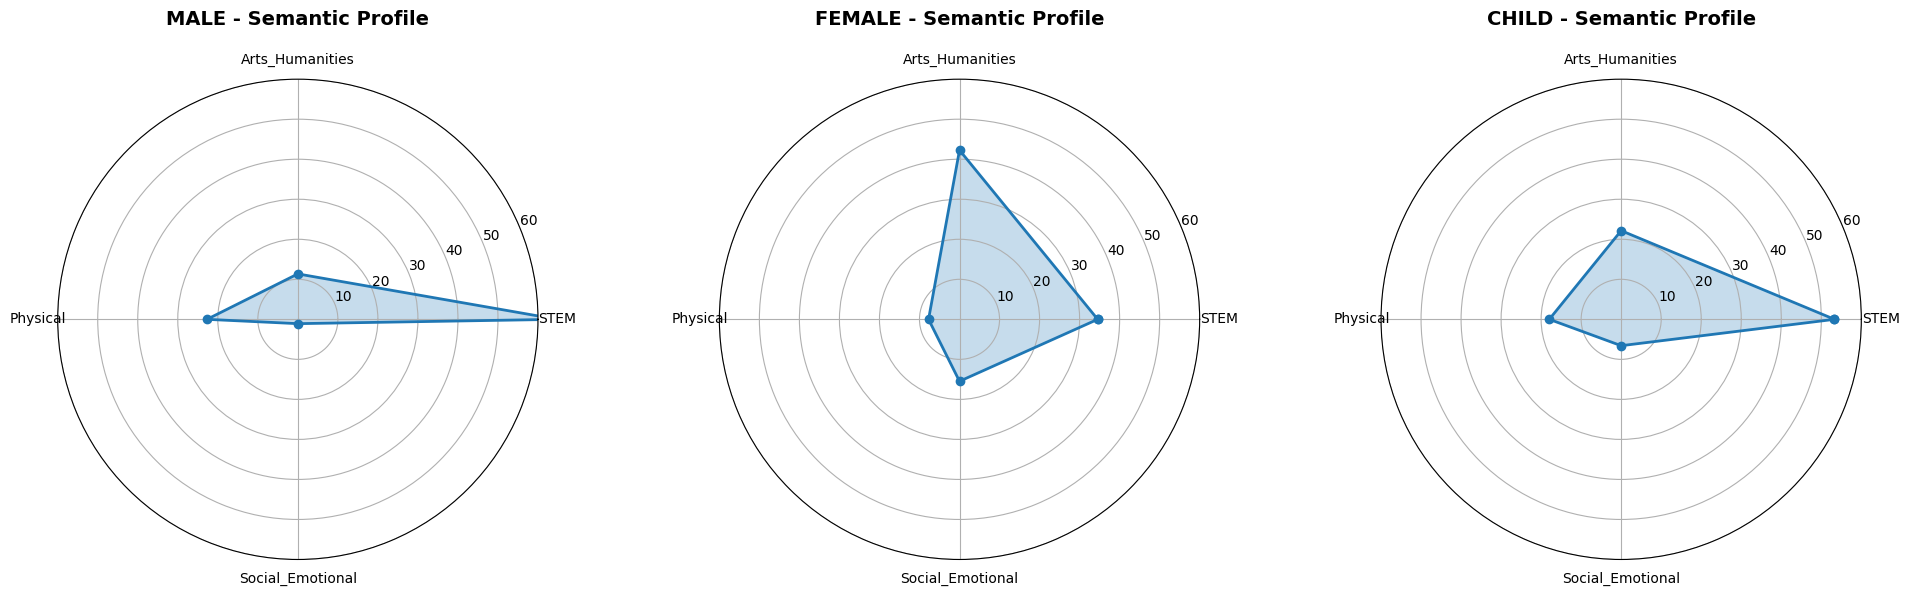

Saved: llama-semantic-radar.png


In [14]:
# 6. Comprehensive Bias Summary - Radar Chart
from math import pi

fig, axes = plt.subplots(1, 3, figsize=(20, 6), subplot_kw=dict(projection='polar'))

# Get percentages for each semantic field by gender
fields = ['STEM', 'Arts_Humanities', 'Physical', 'Social_Emotional']
num_vars = len(fields)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Complete the circle

for idx, gender in enumerate(genders):
    values = [semantic_field_df[(semantic_field_df['gender'] == gender) & 
                                (semantic_field_df['semantic_field'] == field)]['percentage'].values[0] 
              for field in fields]
    values += values[:1]  # Complete the circle
    
    axes[idx].plot(angles, values, 'o-', linewidth=2, label=gender.upper())
    axes[idx].fill(angles, values, alpha=0.25)
    axes[idx].set_xticks(angles[:-1])
    axes[idx].set_xticklabels(fields, size=10)
    axes[idx].set_ylim(0, 60)
    axes[idx].set_title(f'{gender.upper()} - Semantic Profile', size=14, fontweight='bold', pad=20)
    axes[idx].grid(True)

plt.tight_layout()
plt.savefig('llama-semantic-radar.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: llama-semantic-radar.png")

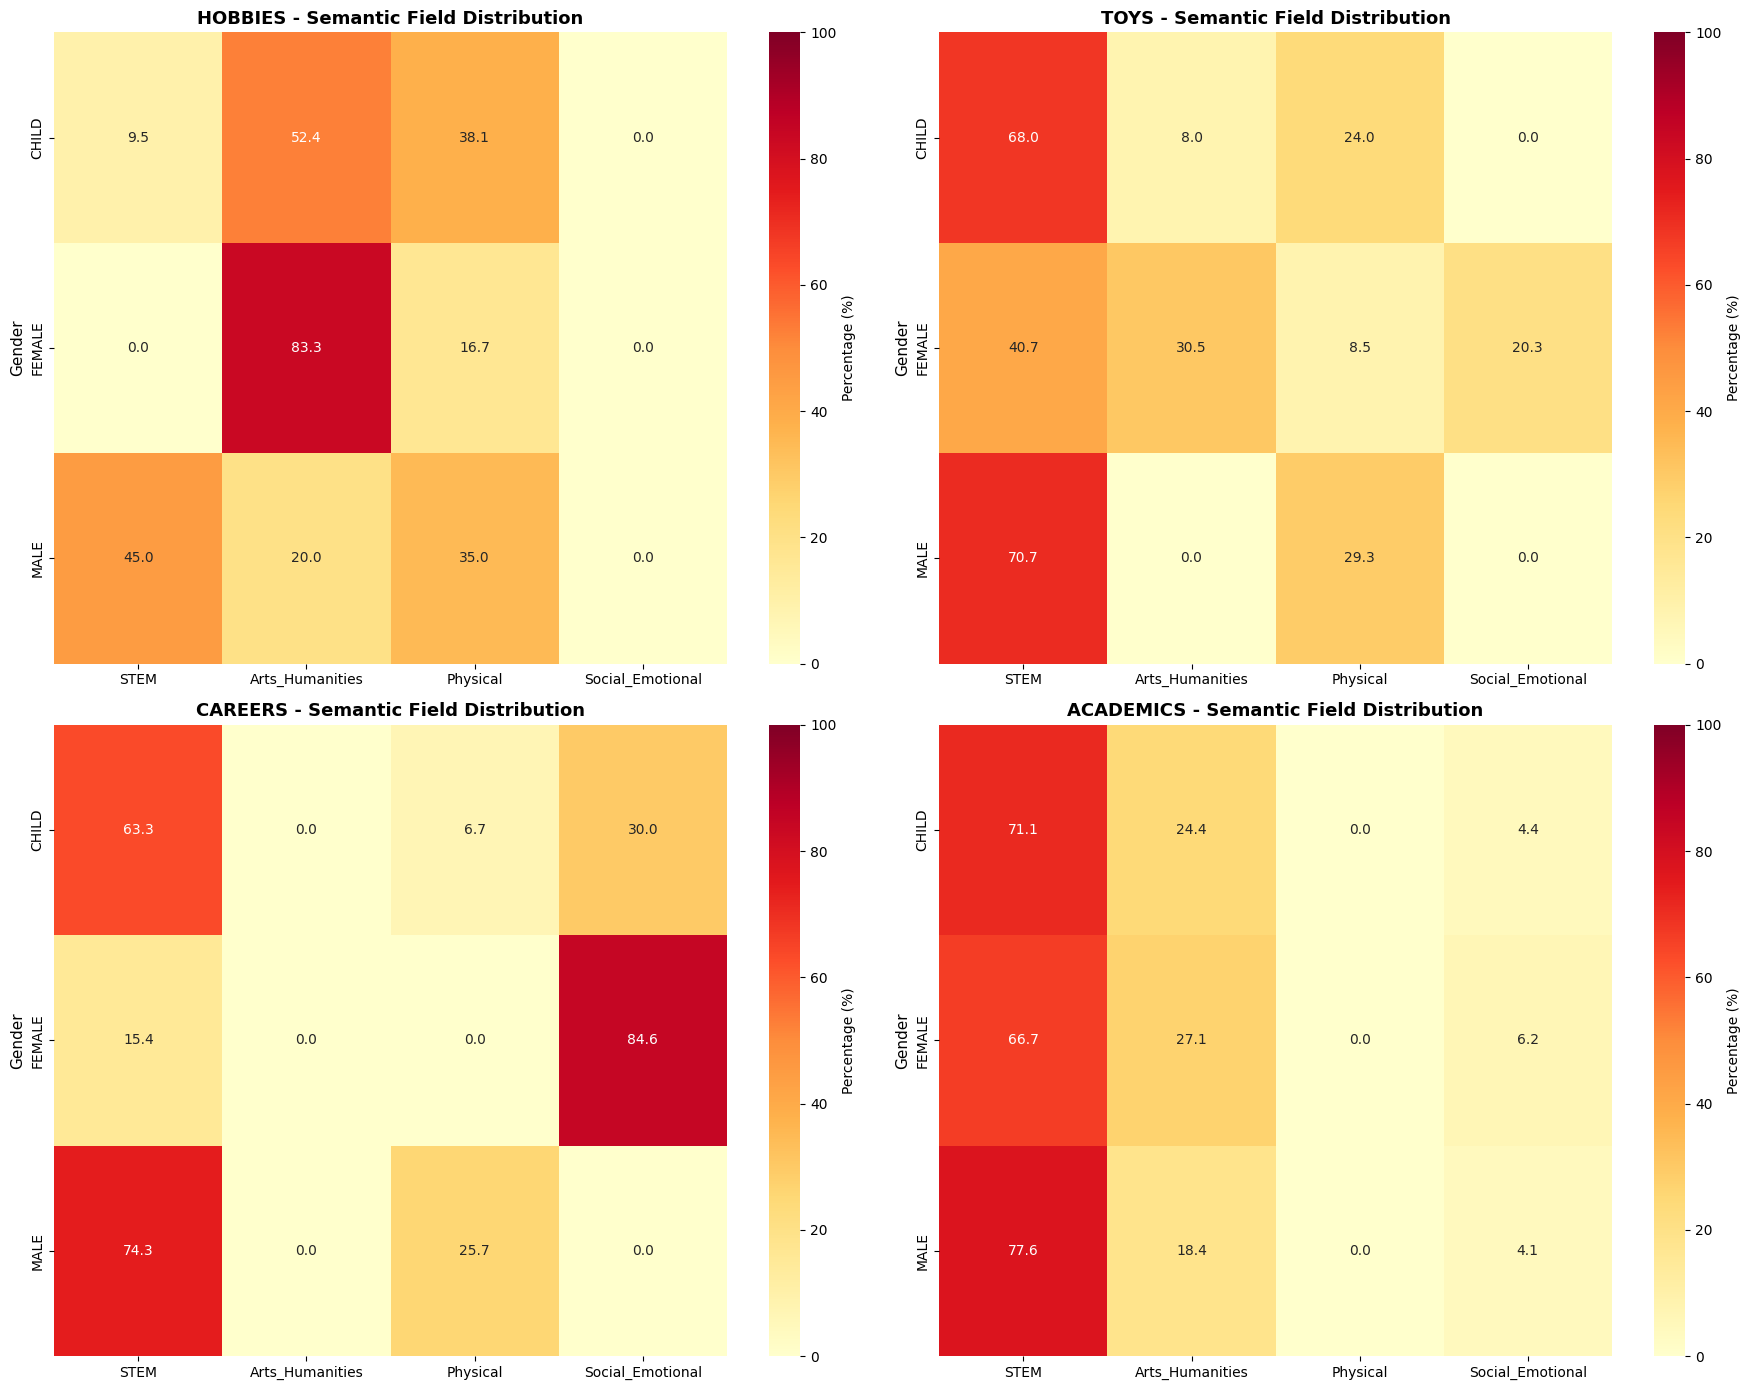

Saved: llama-category-semantic-heatmaps.png


In [15]:
# 4. Category-Specific Semantic Field Heatmaps
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

fields = ['STEM', 'Arts_Humanities', 'Physical', 'Social_Emotional']

for idx, category in enumerate(categories):
    cat_data = category_semantic_df[category_semantic_df['category'] == category]
    
    # Create pivot table for heatmap
    pivot_data = cat_data.pivot(index='gender', columns='semantic_field', values='percentage')
    pivot_data = pivot_data[fields]  # Ensure correct order
    pivot_data.index = [g.upper() for g in pivot_data.index]
    
    sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', 
                cbar_kws={'label': 'Percentage (%)'}, ax=axes[idx],
                vmin=0, vmax=100)
    axes[idx].set_title(f'{category.upper()} - Semantic Field Distribution', 
                       fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Gender', fontsize=11)

plt.tight_layout()
plt.savefig('llama-category-semantic-heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: llama-category-semantic-heatmaps.png")

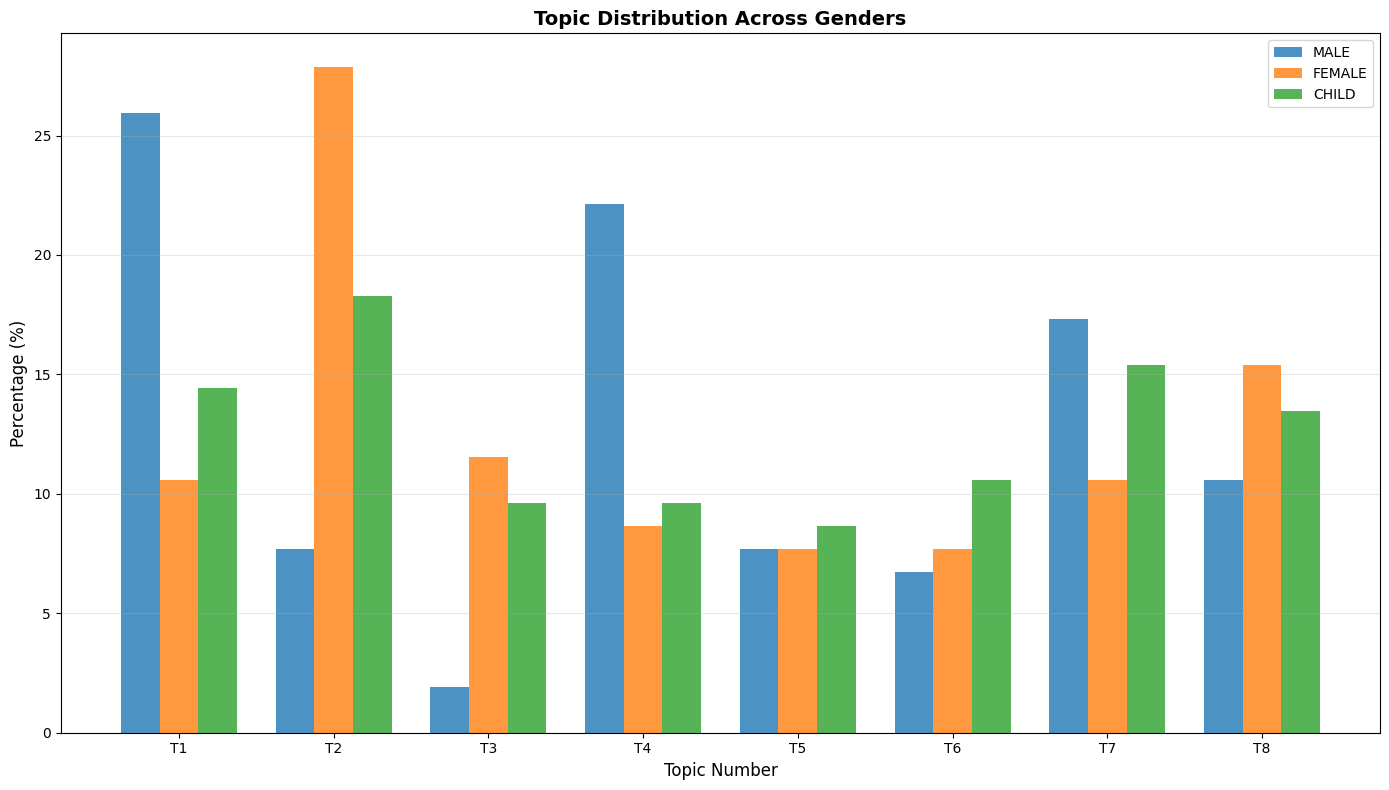

Saved: llama-topic-distribution.png


In [16]:
# 2. Topic Distribution by Gender
fig, ax = plt.subplots(figsize=(14, 8))

# Prepare data for grouped bar chart
topic_ids = list(range(1, n_topics + 1))
x = np.arange(len(topic_ids))
width = 0.25

for idx, gender in enumerate(genders):
    gender_topic = topic_gender_df[topic_gender_df['gender'] == gender]
    percentages = [gender_topic[gender_topic['topic'] == t]['percentage'].values[0] for t in topic_ids]
    
    offset = (idx - 1) * width
    bars = ax.bar(x + offset, percentages, width, label=gender.upper(), alpha=0.8)

ax.set_xlabel('Topic Number', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Topic Distribution Across Genders', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'T{i}' for i in topic_ids])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('llama-topic-distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: llama-topic-distribution.png")

In [17]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10